In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

from matplotlib.colors import LogNorm

sys.path.append("..")
from pysoundloc.visualization import plot_grid, plot_square_grid, plot_mics_and_sources

n_grid_points_per_axis = 25
sigma = 0.5
eps = 1e-7

### Estimate coordinates using likelihood grid

## Generate a random room using SYDRA

In [2]:
from sydra.sydra.generate_dataset import generate_sample

simulation_results, config = generate_sample()

room_dims = np.array(config["room_dims"])[:2]
mic_coords = np.array(config["mic_coordinates"])[:, :2]
source_coords = np.array([config["source_coordinates"]])[:, :2]
sr = config["sr"]

/Users/ezajlerg/src/gnn_ssl/pysoundloc/notebooks/../sydra/sydra/hydra_utils.py:9: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="../config", job_name="_")


## 1. Plot room

<AxesSubplot:xlabel='Width (m)', ylabel='Length (m)'>

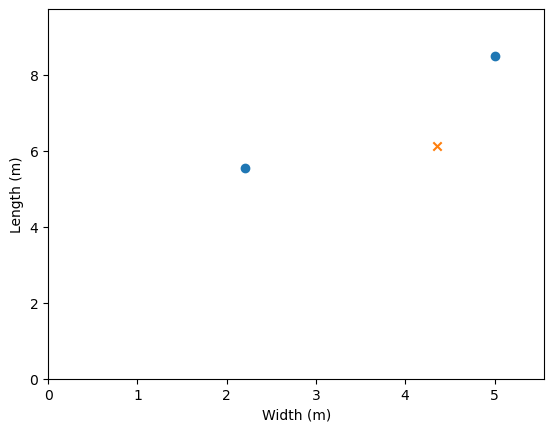

In [9]:
plot_mics_and_sources(room_dims, mic_coords[:2], source_coords)

## 2. Plot distance grid

The distance between a reference point and all the others

/Users/ezajlerg/src/gnn_ssl/pysoundloc/notebooks/../pysoundloc/visualization.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(x_ticks)
/Users/ezajlerg/src/gnn_ssl/pysoundloc/notebooks/../pysoundloc/visualization.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_ticklabels(y_ticks)
/Users/ezajlerg/src/gnn_ssl/pysoundloc/notebooks/../pysoundloc/visualization.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{:.1f}".format(x) for x in x_ticks])
/Users/ezajlerg/src/gnn_ssl/pysoundloc/notebooks/../pysoundloc/visualization.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["{:.1f}".format(y) for y in y_ticks])


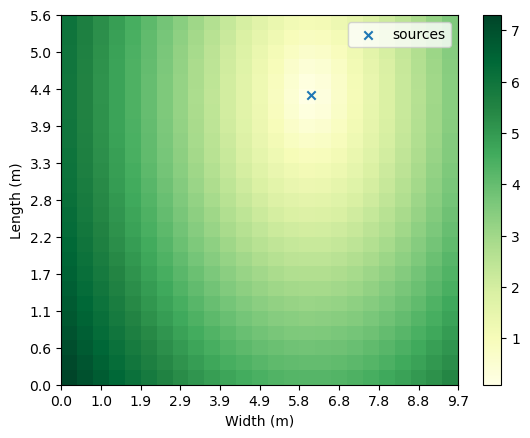

In [4]:
import numpy as np
from pysoundloc.utils.math import compute_distance_grids

distance_grid = compute_distance_grids(source_coords, room_dims[np.newaxis])[0]

ax = plot_grid(distance_grid, room_dims, source_coords=source_coords)

## 2. Plot Theoretical TDOA and energy ratio grids

The difference between two distance grids

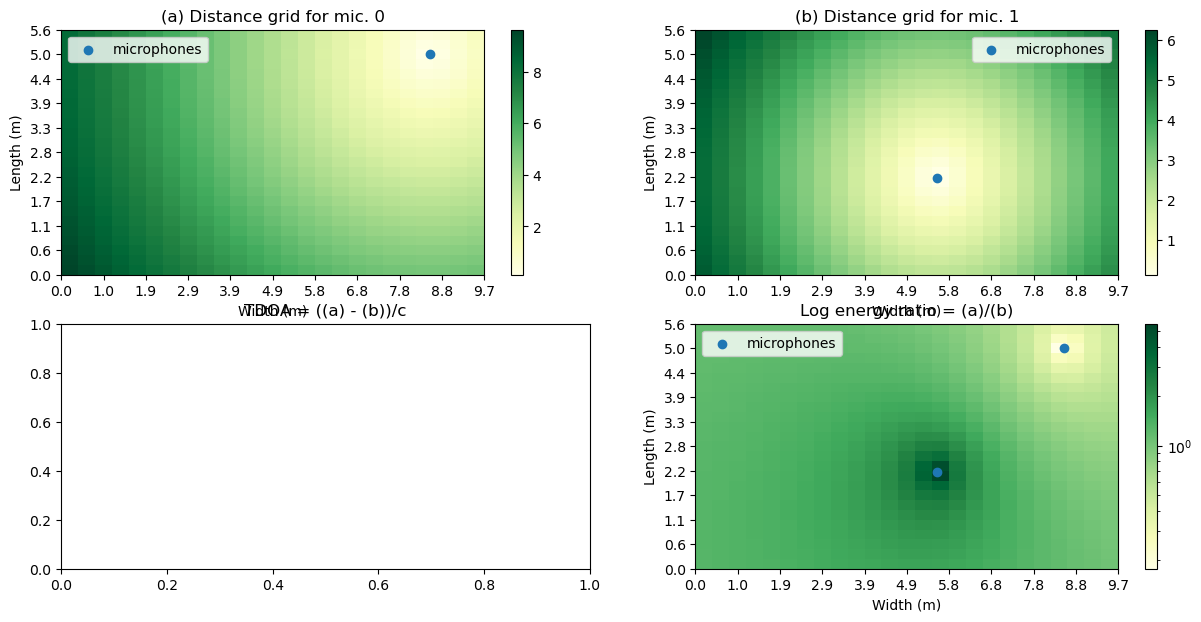

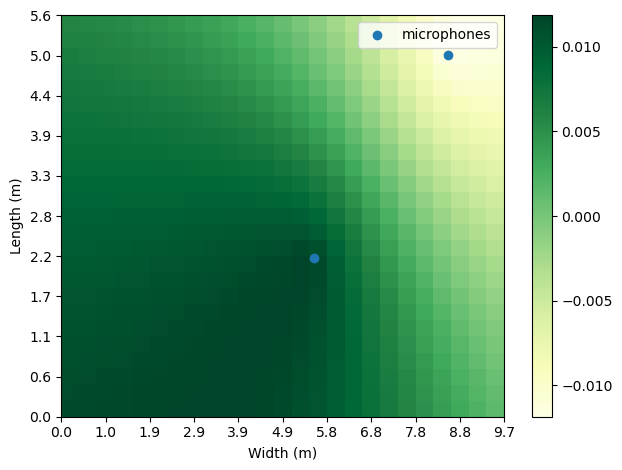

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 7))

distance_grid_0 = compute_distance_grids(mic_coords[0][np.newaxis], room_dims[np.newaxis])[0]

plot_grid(distance_grid_0, room_dims, microphone_coords=mic_coords[0:1], ax=axs[0,0])

distance_grid_1 = compute_distance_grids(mic_coords[1][np.newaxis], room_dims[np.newaxis])[0]

plot_grid(distance_grid_1, room_dims, microphone_coords=mic_coords[1:2], ax=axs[0,1])

tdoa_grid = (distance_grid_0 - distance_grid_1)/343

plot_grid(tdoa_grid, room_dims, microphone_coords=mic_coords[:2])

energy_ratio_grid = np.sqrt((distance_grid_0/distance_grid_1))

plot_grid(energy_ratio_grid, room_dims, microphone_coords=mic_coords[:2], ax=axs[1,1], log=True)


axs[0,0].set_title("(a) Distance grid for mic. 0")

axs[0, 1].set_title("(b) Distance grid for mic. 1")
                 
axs[1, 0].set_title("TDOA = ((a) - (b))/c")

axs[1, 1].set_title("Log energy ratio = (a)/(b)")

plt.tight_layout()

## 3. Cross-correlation between microphone signals

(1, 16000)


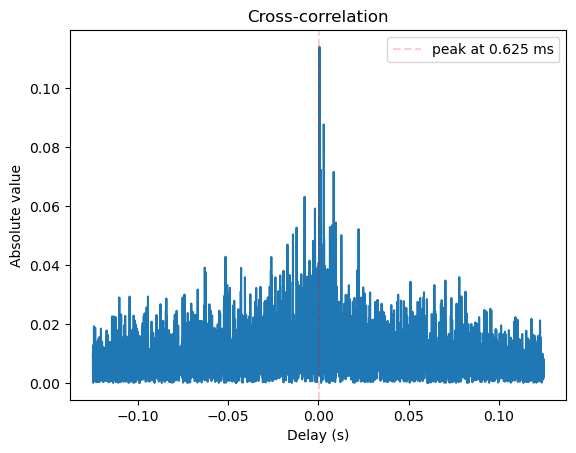

In [6]:
from pysoundloc.gcc_phat import gcc_phat_batch

correlation, lags = gcc_phat_batch(simulation_results[:1], simulation_results[1:2], 16000)

lags = lags[6000:10000]
correlation = np.abs(correlation[0, 6000:10000])

print(simulation_results[:1].shape)
plt.title("Cross-correlation")
plt.plot(lags, correlation)
plt.xlabel("Delay (s)")
plt.ylabel("Absolute value")

peak = np.argmax(correlation)
lag_peak = lags[peak]

plt.axvline(x=lag_peak, label="peak at {} ms".format(1000*lag_peak), color="r", alpha=0.2, linestyle="--")

plt.legend()

## 4. SRP-PHAT: Projecting the CC in space

(<matplotlib.collections.QuadMesh at 0x28dd7fdc0>,
 <AxesSubplot:xlabel='Width (m)', ylabel='Length (m)'>)

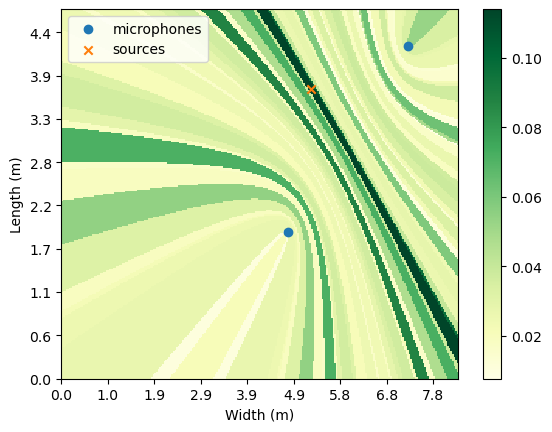

In [8]:
from pysoundloc.models import srp_phat

results = srp_phat(simulation_results[np.newaxis],
                                   mic_coords[np.newaxis],
                                   np.array(room_dims)[np.newaxis],
                                   sr, n_grid_points=256,
                                   return_grid_pairs=True)


plot_grid(results["grid"][0, 0, 1], room_dims, microphone_coords=mic_coords[:2], source_coords=source_coords)


## 1. Likelihood grid: Target used for training

In [ ]:
from pysoundloc.target_grids import create_target_gaussian_grids, create_target_hyperbolic_grids

fig, axs = plt.subplots(ncols=3, figsize=(15,5))

target_likelihood_grid = create_target_gaussian_grids(
                    source_coords[np.newaxis], np.array(room_dims)[np.newaxis], sigma=sigma)[0]

target_srp_grid = create_target_hyperbolic_grids(source_coords[np.newaxis],
                                         mic_coords[np.newaxis, 0],
                                         mic_coords[np.newaxis, 2],
                                         room_dims,
                                         n_grid_points_per_axis,
                                         sigma=sigma,
                                         log=False)[0]

hybrid_grid = target_srp_grid + 0.6*target_likelihood_grid
hybrid_grid /= hybrid_grid.max()

plot_grid(target_likelihood_grid, room_dims, source_coords=source_coords, microphone_coords=mic_coords[[0, 1]], log=False, ax=axs[0])
plot_grid(target_srp_grid, room_dims, source_coords=source_coords, microphone_coords=mic_coords[[0, 2]], log=False, ax=axs[1])
plot_grid(hybrid_grid, room_dims, source_coords=source_coords, microphone_coords=mic_coords[[0, 1]], log=False, ax=axs[2])

axs[0].set_title("Gaussian likelihood grid")
axs[1].set_title("Hyperbolic likelihood grid")
axs[2].set_title("Hybrid grid")

plt.tight_layout()

plt.savefig("grids.pdf")

## 1.1 Different sigmas

In [ ]:

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,5))

sigmas = [0.1, 0.5, 1]

for i, s in enumerate(sigmas):
    target_likelihood_grid = create_target_gaussian_grids(
                        source_coords[np.newaxis], np.array(room_dims)[np.newaxis], sigma=s)[0]

    target_srp_grid = create_target_hyperbolic_grids(source_coords[np.newaxis],
                                             mic_coords[np.newaxis, 0],
                                             mic_coords[np.newaxis, 1],
                                             room_dims,
                                             n_grid_points_per_axis,
                                             sigma=s,
                                             log=False)[0]

    axs[0, i].set_title(f"Sigma={s}")
    
    plot_grid(target_likelihood_grid, room_dims, source_coords=source_coords, microphone_coords=mic_coords[[0, 1]], log=False, ax=axs[0, i])
    plot_grid(target_srp_grid, room_dims, source_coords=source_coords, microphone_coords=mic_coords[[0, 1]], log=False, ax=axs[1, i])

axs[0, 0].set_ylabel(f"Gaussian likelihood grid")
axs[1, 0].set_ylabel(f"Hyperbolic likelihood grid")
    

# axs[0].set_title("Gaussian likelihood grid")
# axs[1].set_title("Hyperbolic likelihood grid")
# axs[2].set_title("Hybrid grid")

plt.tight_layout()

plt.savefig("sigmas.pdf")

# 1. Energy ratio grid

In [ ]:
from pysoundloc.models import energy_ratio_ssl

estimated_coords, energy_ratio_grids = energy_ratio_ssl(simulation_results[np.newaxis],
                                               mic_coords[np.newaxis], np.array(room_dims)[np.newaxis],
                                               sr, n_grid_points=256, return_grid_pairs=True)
    

axs = plot_square_grid(energy_ratio_grids[0], room_dims, mic_coords, source_coords, log=True)
# plot_grid(grid, room_dims, microphone_coords=mic_coords[[0, 1]], source_coords=source_coords, log=False)

print(estimated_coords, source_coords)

# 2. Spatial correlation grid
Used as an input feature for localization algorithms 

[[3.66040623 6.56077507]] [[4.35619469 6.12787032]]


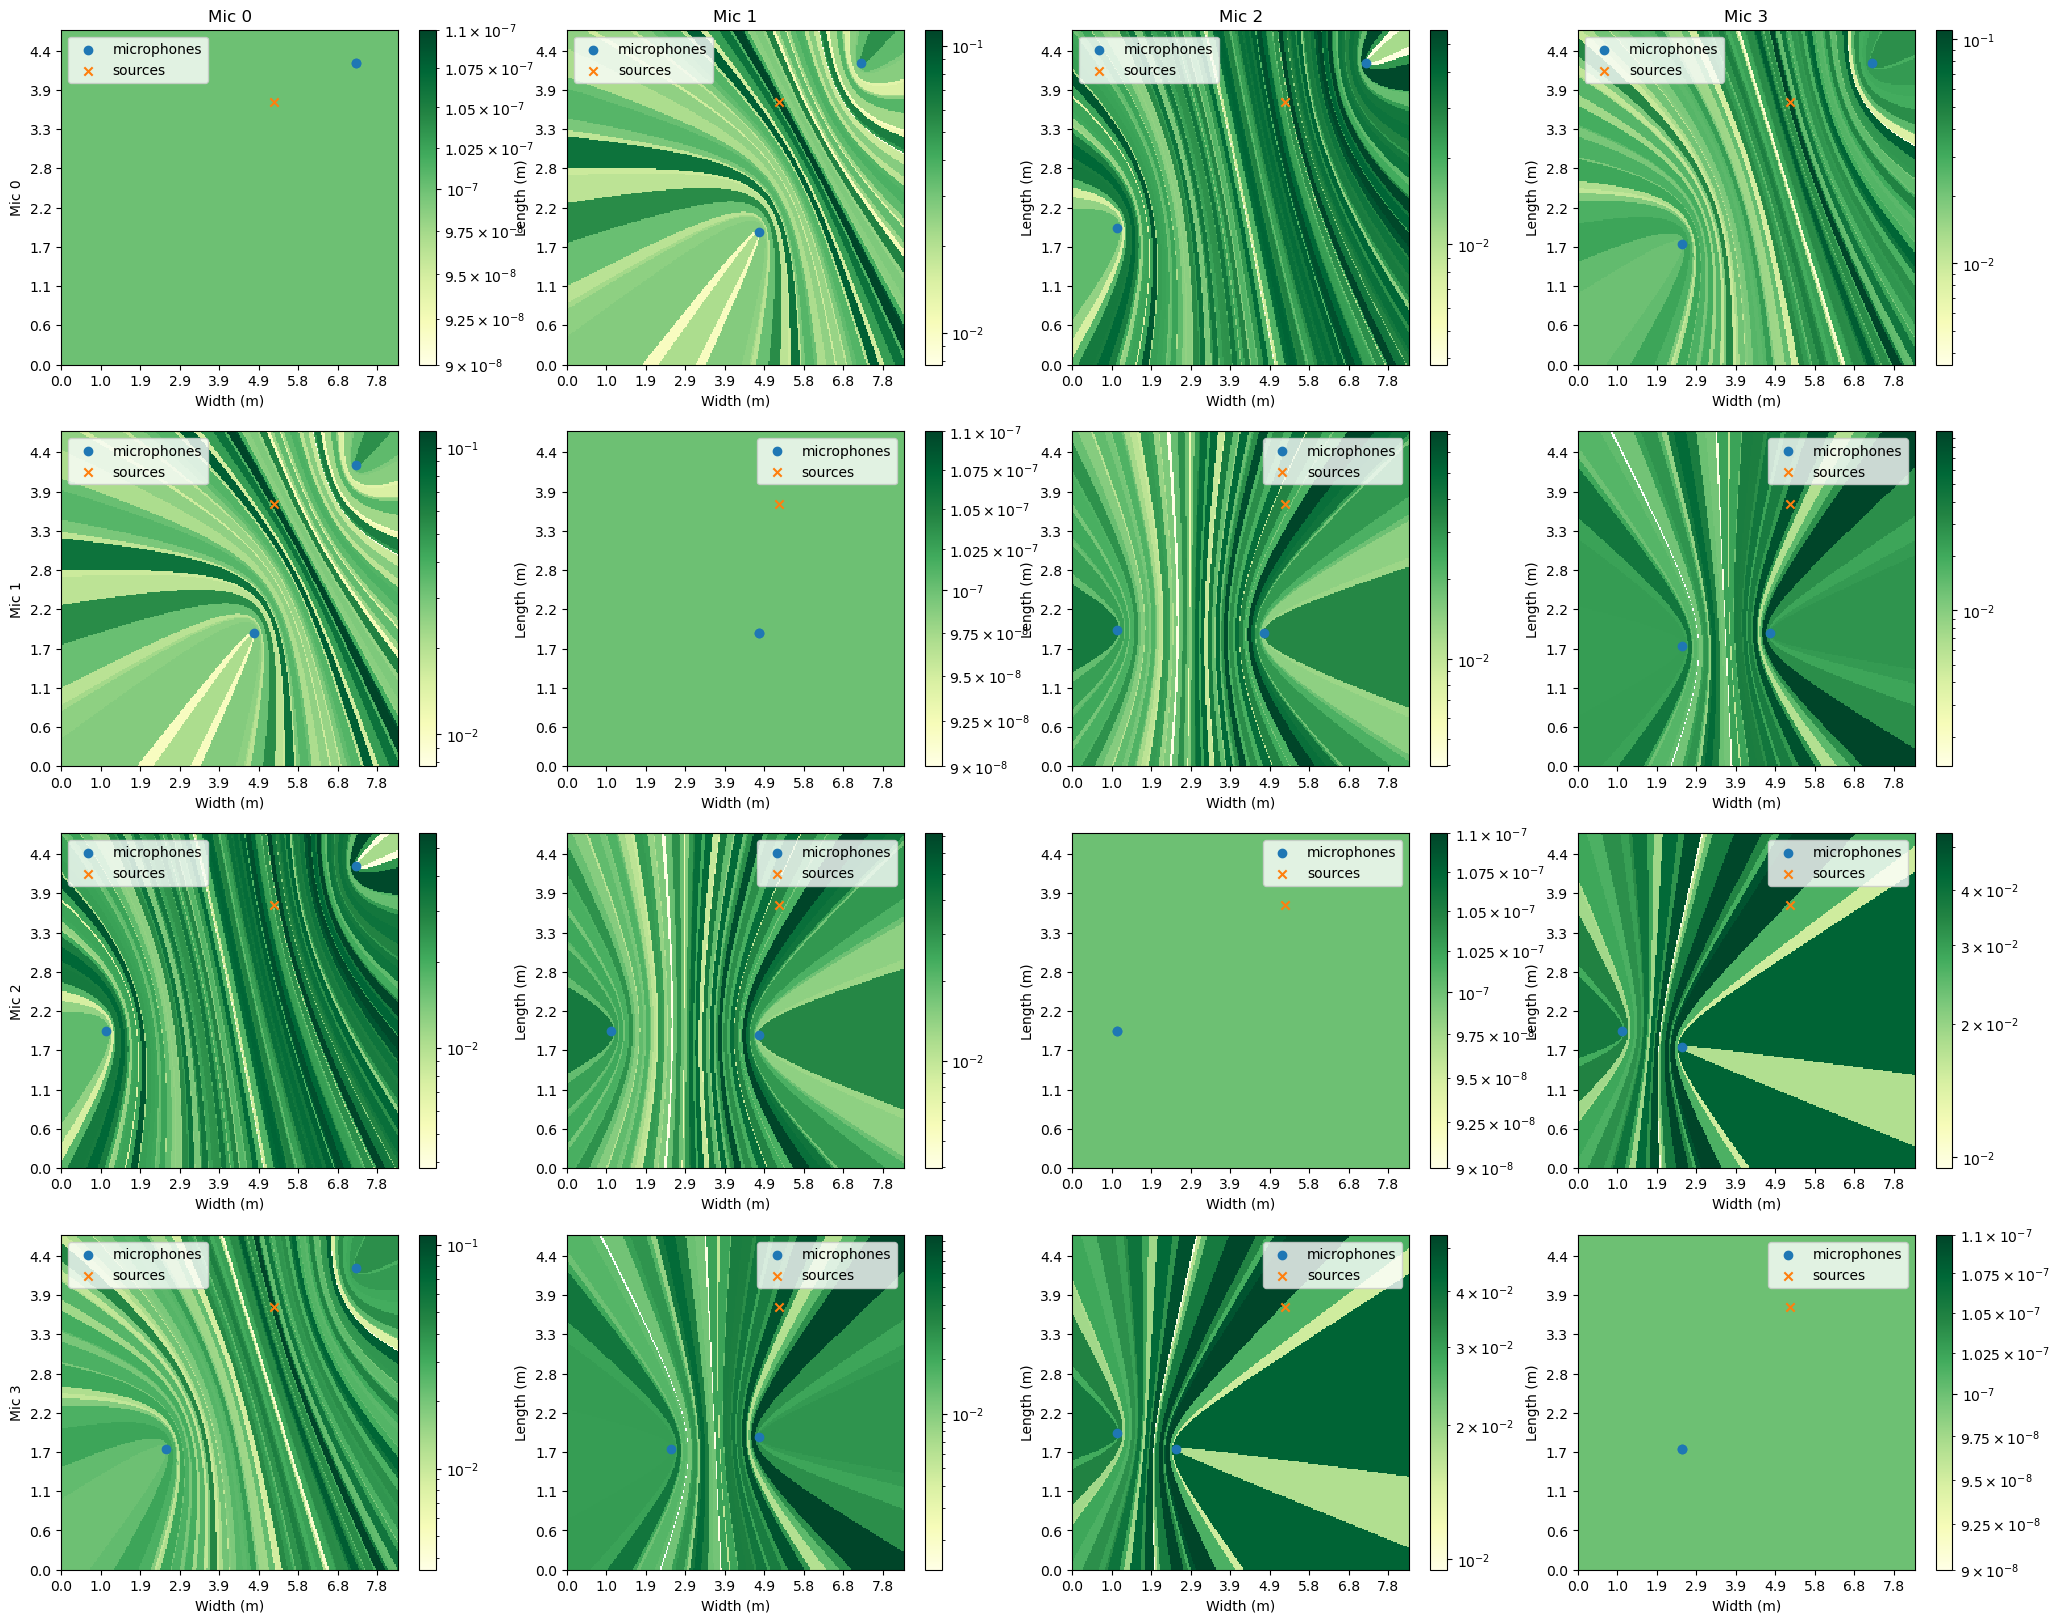

In [13]:
from pysoundloc.models import srp_phat

# Compute spatial likelihood functions for all microphones

results = srp_phat(simulation_results[np.newaxis],
                                   mic_coords[np.newaxis],
                                   np.array(room_dims)[np.newaxis],
                                   sr, n_grid_points=256,
                                   return_grid_pairs=True)

axs = plot_square_grid(results["grid"][0], room_dims, mic_coords, source_coords, log=True)

print(results["source_coordinates"], source_coords)

[[3.66040623 6.56077507]] [[4.35619469 6.12787032]]


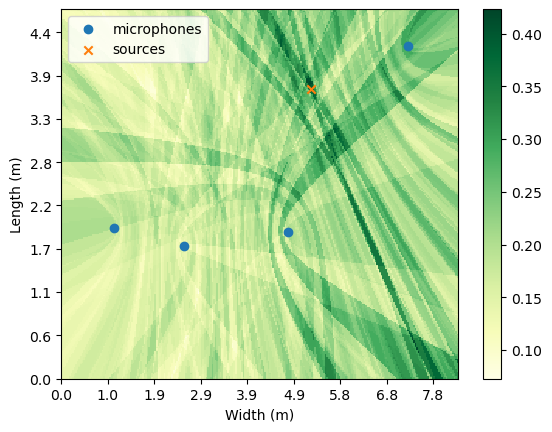

In [15]:

results = srp_phat(simulation_results[np.newaxis],
                                   mic_coords[np.newaxis],
                                   np.array(room_dims)[np.newaxis],
                                   sr, n_grid_points=256,
                                   return_grid_pairs=False)

axs = plot_grid(results["grid"][0], room_dims, mic_coords, source_coords, log=False)

print(results["source_coordinates"], source_coords)

## 3. TDOA grid
An alternative to the Spatial Likelihood grid

In [ ]:
from pysoundloc.models import tdoa_least_squares_ssl

estimated_coords, ls_grids = tdoa_least_squares_ssl(simulation_results[np.newaxis],
                                               mic_coords[np.newaxis], np.array(room_dims)[np.newaxis],
                                               sr, n_grid_points=256, return_grid_pairs=True)
    

axs = plot_square_grid(ls_grids[0], room_dims, mic_coords, source_coords, log=True)
# plot_grid(grid, room_dims, microphone_coords=mic_coords[[0, 1]], source_coords=source_coords, log=False)

## Compare estimates using the three methods

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(20, 5))

methods = {
    "TDOA": tdoa_least_squares_ssl,
    "SLF": srp_phat,
    #"Energy ratios": energy_ratio_ssl,
}

for i, (method_name, method_func) in enumerate(methods.items()):
    estimated_location, grid_sum = method_func(simulation_results[np.newaxis],
                                                 mic_coords[np.newaxis],
                                                 np.array(room_dims)[np.newaxis],
                                                 sr, n_grid_points=256)#, agg_mode="sum")
    
    #grid_sum = np.clip(grid_sum, None, 1000)
    plot_grid(grid_sum[0],
          room_dims,
          microphone_coords=mic_coords,
          source_coords=source_coords,
          log=True,
          ax=axs[i])
    
    axs[i].set_title(method_name)
    
    error = np.sqrt(np.sum((estimated_location - source_coords[:, :2])**2))
    print(f"{method_name}", error)
    


In [ ]:
from matplotlib.ticker import MaxNLocator
fig, axs = plt.subplots(3, 2, figsize=(7, 6))
#plt.rcParams['text.usetex'] = False


for i in range(2):
    # Plot least squares grid
    plot_grid(ls_grids[0,0,i+1],
          room_dims,
          microphone_coords=mic_coords[[0, i+1]],
          source_coords=source_coords,
          log=True,
          ax=axs[i, 0],
          colorbar=False)
    # Plot slf grid
    plot_grid(slf_grids[0,0,i+1],
      room_dims,
      microphone_coords=mic_coords[[0, i+1]],
      source_coords=source_coords,
      log=True,
      ax=axs[i, 1],
      colorbar=False)
    
    axs[i, 0].axes.get_xaxis().set_visible(False)
    axs[i, 1].axes.get_xaxis().set_visible(False)
    axs[i, 0].set_yticks([])
    axs[i, 1].yaxis.tick_right()
        
    if i > 0:
        axs[i, 0].legend_ = None
        #axs[i, 0].axes.get_xaxis().set_visible(False)
        #axs[i, 1].axes.get_xaxis().set_visible(False)
    else:
        axs[i, 0].set_title("TDOA")
        axs[i, 1].set_title("SLF")
        axs[i, 0].set_xticks([])
        axs[i, 1].set_xticks([])
        
    axs[i, 1].legend_ = None
    
    axs[i, 0].set_ylabel(f"$f(x_{1}, x_{i+2})$")
    
    axs[i, 1].yaxis.set_major_locator(MaxNLocator(7)) 
    axs[i, 1].yaxis.tick_right()
    axs[i,1].yaxis.set_label_position("right")
# Plot the sum

plot_grid(ls_grids[0,0, 1] + ls_grids[0, 0, 2],
      room_dims,
      microphone_coords=mic_coords[[0, 1, 2]],
      source_coords=source_coords,
      log=True,
      ax=axs[-1, 0],
      colorbar=False)
        
#axs[0,-1].axes.get_yaxis().set_visible(False)
#axs[0,-1].axes.get_yaxis().set_visible(False)

plot_grid(slf_grids[0,0, 1] + slf_grids[0, 0, 2],
      room_dims,
      microphone_coords=mic_coords[[0, 1, 2]],
      source_coords=source_coords,
      log=True,
      ax=axs[-1,1],
      colorbar=False)
        
#axs[1,-1].axes.get_xaxis().set_visible(False)
#axs[1,-1].axes.get_yaxis().set_visible(False)
axs[-1,0].yaxis.tick_right()
axs[-1,1].yaxis.tick_right()
axs[-1,1].yaxis.set_label_position("right")
axs[-1,1].yaxis.set_major_locator(MaxNLocator(7)) 
axs[-1, 0].xaxis.set_major_locator(MaxNLocator(7)) 
axs[-1,1].xaxis.set_major_locator(MaxNLocator(7)) 

axs[-1, 0].set_ylabel("$f(x_{1}, x_{2}) + f(x_{1}, x_{3})$")
#axs[-1,0].axes.get_yaxis().set_visible(False)
axs[-1, 0].set_yticks([])
axs[-1, 0].legend_ = None
axs[-1, 1].legend_ = None

plt.tight_layout()
plt.savefig("f.pdf")